# DATA EXPLAINED
-  data_full.json: clinic150 dataset including out of scope and in scope intent labels with test train split

-  filtered_train: test val and train merged to create a single train for possible merged data and removal of out of labels, filtered labels down to 15 to include intents specified for a travel aimed chatting agent.
included labels:

        {'cancel_reservation', 'restaurant_suggestion', 'flight_status', 'travel_alert', 'travel_suggestion', 'current_location', 'weather', 'lost_luggage', 'book_flight', 'car_rental', 'pay_bill', 'schedule_meeting', 'book_hotel', 'directions', 'restaurant_reservation'}

-  test,train,val_data: train_test_split with 75/15/15 on filtered_train.json

## 1. Preprocessing

### 1.1. Import necessary libraries

In [1]:
import json
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from sklearn.model_selection import train_test_split
import random
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
import nltk
import json
from sklearn.feature_extraction.text import CountVectorizer

Additional code block for Sima's notebook - spaCy did not work as intended without downloading 

In [2]:
import spacy.cli

# Load spacy model for NER
nlp = spacy.load("en_core_web_sm")

### 1.2. Load the data

In [3]:
# all intents in CLINIC150
with open('Files/data_full.json', 'r') as file:
    data = json.load(file)
    
intents = set(intent for _, intent in data["train"])
print(intents)

{'replacement_card_duration', 'calendar', 'redeem_rewards', 'income', 'pto_request_status', 'book_flight', 'who_do_you_work_for', 'ingredient_substitution', 'update_playlist', 'spending_history', 'todo_list_update', 'new_card', 'mpg', 'make_call', 'thank_you', 'what_can_i_ask_you', 'rollover_401k', 'change_accent', 'reminder', 'traffic', 'card_declined', 'translate', 'yes', 'date', 'min_payment', 'sync_device', 'where_are_you_from', 'damaged_card', 'directions', 'shopping_list_update', 'change_speed', 'international_visa', 'oil_change_when', 'are_you_a_bot', 'timezone', 'shopping_list', 'insurance_change', 'next_song', 'no', 'accept_reservations', 'travel_notification', 'credit_score', 'schedule_maintenance', 'car_rental', 'application_status', 'uber', 'text', 'travel_alert', 'pin_change', 'find_phone', 'cook_time', 'meal_suggestion', 'carry_on', 'do_you_have_pets', 'lost_luggage', 'maybe', 'tire_pressure', 'share_location', 'meaning_of_life', 'calculator', 'account_blocked', 'what_son

### 1.3. Train-Validation-Test split with (0.7 - 0.15 - 0.15)

In [4]:
#extracting the sentences and intents 
sentences = [sentence for sentence, _ in data["train"]]
intents = [intent for _, intent in data["train"]]

#spliting the data into train 0.7 and temp 0.3 sets
X_train, X_temp, y_train, y_temp = train_test_split(sentences, intents, test_size=0.3, random_state=42)

#Split the temp set into validation0.5 and tes t0.5 sets total of 015 of entire data, 
#also setting random seed to 42 for consistency
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#Creating dictionaries for the splits
train_data = {"train": list(zip(X_train, y_train))}
val_data = {"train": list(zip(X_val, y_val))}
test_data = {"train": list(zip(X_test, y_test))}

# Saveing the splits into Json, to files directory
with open('Files/train_data.json', 'w') as file:
    json.dump(train_data, file, indent=4)

with open('Files/val_data.json', 'w') as file:
    json.dump(val_data, file, indent=4)

with open('Files/test_data.json', 'w') as file:
    json.dump(test_data, file, indent=4)

Print shapes of train, validation and test datasets

In [5]:
#shape of test train val sets
print("Train set shape:", len(X_train))
print("Validation set shape:", len(X_val))
print("Test set shape:", len(X_test))

Train set shape: 15750
Validation set shape: 3375
Test set shape: 3375


### 1.4. Plot the distribution of class labels

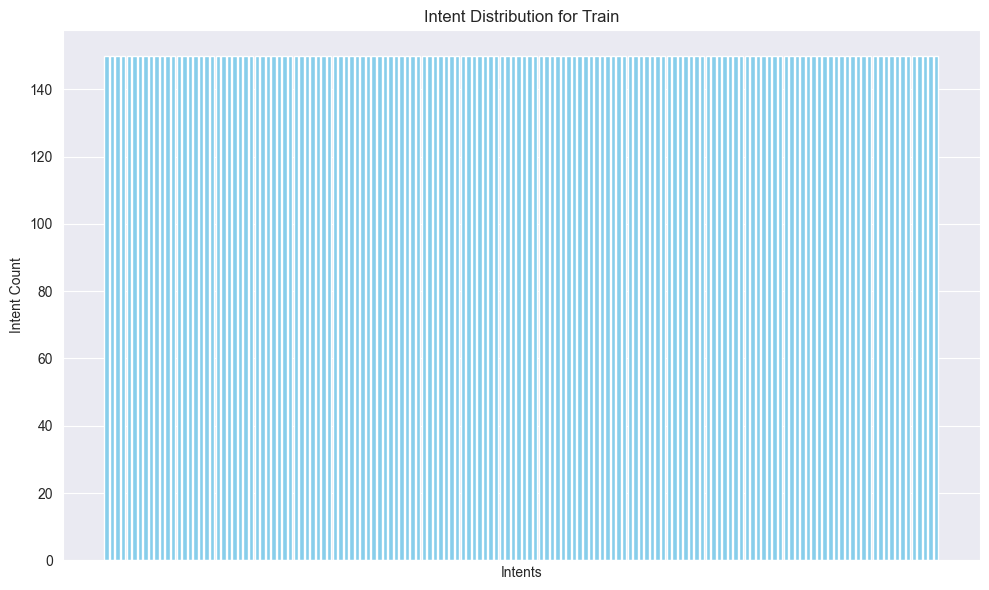

In [6]:
# intent counts under train(every data is under train in the json, train is used the same as the word data)
intents = [intent for _, intent in data["train"]]
intent_counts = Counter(intents)

# ploting the histogram of label distributions for every intent
plt.figure(figsize=(10, 6))
plt.bar(range(len(intent_counts)), intent_counts.values(), color='skyblue')
plt.xlabel('Intents')
plt.ylabel('Intent Count')
plt.title('Intent Distribution for Train')

#removing x-axis labels as 150 class labels make the table hard to interpret
plt.xticks([])  # Removes x-axis labels
plt.tight_layout()
plt.show()

### 1.5. Preprocessing algorithm for lemmatization

In [7]:
#downloading required nltk resources
nltk.download('punkt')
nltk.download('wordnet')

#initializing a lemmatizer, uaing wordnet
lemmatizer = WordNetLemmatizer()


#function for text cleaning and preprocessing
def preprocess_text(text):
    
    text = text.lower()#lower text
    text = re.sub(r'[^a-z0-9\s]', '', text)# remove non alphanumeric
    tokens = word_tokenize(text)#tokenize
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]#lemmatization
    
    #returns the processed strings
    return ' '.join(lemmatized_tokens)

[nltk_data] Downloading package punkt to /Users/sima/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sima/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# function for extracting n-grams 1-3
def extract_ngrams(text, n=1):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return [' '.join(grams) for grams in n_grams]

# function for NER with sapcy
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

def extract_features(query):
    # 1-3 grams
    unigrams = extract_ngrams(query, 1)
    bigrams = extract_ngrams(query, 2)
    trigrams = extract_ngrams(query, 3)
    
    # NER with spaCy
    entities = extract_entities(query)
    
    #combining fetures NER and n-grams
    features = unigrams + bigrams + trigrams + entities  
    return ' '.join(features)

#preprocessing and extracting features for all data
processed_data = []
for query, intent in data["train"]:
    preprocessed_query = preprocess_text(query)
    features = extract_features(preprocessed_query)
    processed_data.append((features, intent))

# prints first 100 intent features
for i, (features, intent) in enumerate(processed_data):
    if i < 100:
        print(f"\n**********\nFeatures: {features}\nIntent: {intent}\n**********\n")
    else:
        break


**********
Features: in spanish meet me tomorrow is said how in spanish spanish meet meet me me tomorrow tomorrow is is said said how in spanish meet spanish meet me meet me tomorrow me tomorrow is tomorrow is said is said how spanish tomorrow
Intent: translate
**********


**********
Features: in french how do i say see you later in french french how how do do i i say say see see you you later in french how french how do how do i do i say i say see say see you see you later french
Intent: translate
**********


**********
Features: how do you say hello in japanese how do do you you say say hello hello in in japanese how do you do you say you say hello say hello in hello in japanese japanese
Intent: translate
**********


**********
Features: how do i ask about the weather in chinese how do do i i ask ask about about the the weather weather in in chinese how do i do i ask i ask about ask about the about the weather the weather in weather in chinese chinese
Intent: translate
**********

## 2. Classification Models

### 2.1. TF-iDF Classifiers

#### 2.1.1. Import necessary libraries for classification

In [15]:
#all neccessary imports for the project
import numpy as np
import pandas as pd
import spacy
import json

from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import re
from tqdm import tqdm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from matplotlib.backends.backend_pdf import PdfPages

Download necessary NLTK data

In [16]:
# Download required NLTK data
nltk.download('averaged_perceptron_tagger')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sima/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### 2.1.2. Define a feature extraction class

In [17]:
class FeatureExtractor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.feature_types = {}
    
    def extract_ngrams(self, text, n=1):
        tokens = word_tokenize(text)
        n_grams = ngrams(tokens, n)
        return [' '.join(grams) for grams in n_grams]
    
    def add_feature_type(self, feature, feature_type):
        if feature not in self.feature_types:
            self.feature_types[feature] = []
        self.feature_types[feature].append(feature_type)
    
    def preprocess_text(self, text):
        # Basic cleaning
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', '', text)
        
        # Lemmatization
        tokens = word_tokenize(text)
        lemmatized = [self.lemmatizer.lemmatize(word) for word in tokens]
        for lemma in lemmatized:
            self.add_feature_type(lemma, "lemma")
        
        
        # Additional features
        doc = nlp(text)
        
        # POS tags
        pos_tags = [token.pos_ for token in doc]
        for pos in pos_tags:
            self.add_feature_type(pos, "pos")
        
        # Named entities
        entities = [ent.label_ for ent in doc.ents]
        for entity in entities:
            self.add_feature_type(entity, "entity")
        
        # Dependencies
        deps = [token.dep_ for token in doc]
        for dep in deps:
            self.add_feature_type(dep, "dependency")
        
        # Ngrams
        unigrams = self.extract_ngrams(text, 1)
        bigrams = self.extract_ngrams(text, 2)
        trigrams = self.extract_ngrams(text, 3)
        for unigram in unigrams:
            self.add_feature_type(unigram, "unigram")
        for bigram in bigrams:
            self.add_feature_type(bigram, "bigram")
        for trigram in trigrams:
            self.add_feature_type(trigram, "trigram")
        
        # Combine all features
        features = lemmatized + pos_tags + entities + deps + unigrams + bigrams + trigrams
        
        return ' '.join(features)

#### 2.1.3. Define utility functions

In [12]:
def load_data():
    
    with open('Files/train_data.json', 'r') as file:
        train_data = json.load(file)
    
    with open('Files/val_data.json', 'r') as file:
        val_data = json.load(file)
    
    X_train = [text for text, _ in train_data['train']]
    y_train = [intent for _, intent in train_data['train']]
    
    X_val = [text for text, _ in val_data['train']]
    y_val = [intent for _, intent in val_data['train']]
    
    return X_train, y_train, X_val, y_val



def plot_confusion_matrix(y_true, y_pred, labels, output_file):
    
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(20, 20))
    
    sns.heatmap(
        cm, 
        annot=True,
        annot_kws={"size": 6},
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        cbar=True
    )
    
    ax.set_title('Confusion Matrix', fontsize=16)
    ax.set_xlabel('Predicted Labels', fontsize=14)
    ax.set_ylabel('True Labels', fontsize=14)
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=90, fontsize=6, ha='center')
    ax.set_yticklabels(labels, fontsize=6)
    

    with PdfPages(output_file) as pdf:
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
    
    print(f"Confusion matrix saved to {output_file}")

#### 2.1.4. Classifiers

**2.1.4.1. tf-idf with MultinomialNB**

Preprocessing training data...
Preprocessing validation data...
Training classifier...
Making predictions...
Confusion matrix saved to multinomialnb_confusion_matrix.pdf

Classification Report:
                           precision    recall  f1-score   support

      accept_reservations       0.94      0.94      0.94        17
          account_blocked       0.88      0.70      0.78        20
                    alarm       0.93      0.93      0.93        27
       application_status       0.88      0.96      0.92        23
                      apr       0.96      0.96      0.96        23
            are_you_a_bot       0.80      0.92      0.86        13
                  balance       0.96      0.90      0.93        30
             bill_balance       0.85      0.74      0.79        23
                 bill_due       0.88      0.96      0.92        23
              book_flight       1.00      1.00      1.00        19
               book_hotel       1.00      0.94      0.97        18
 

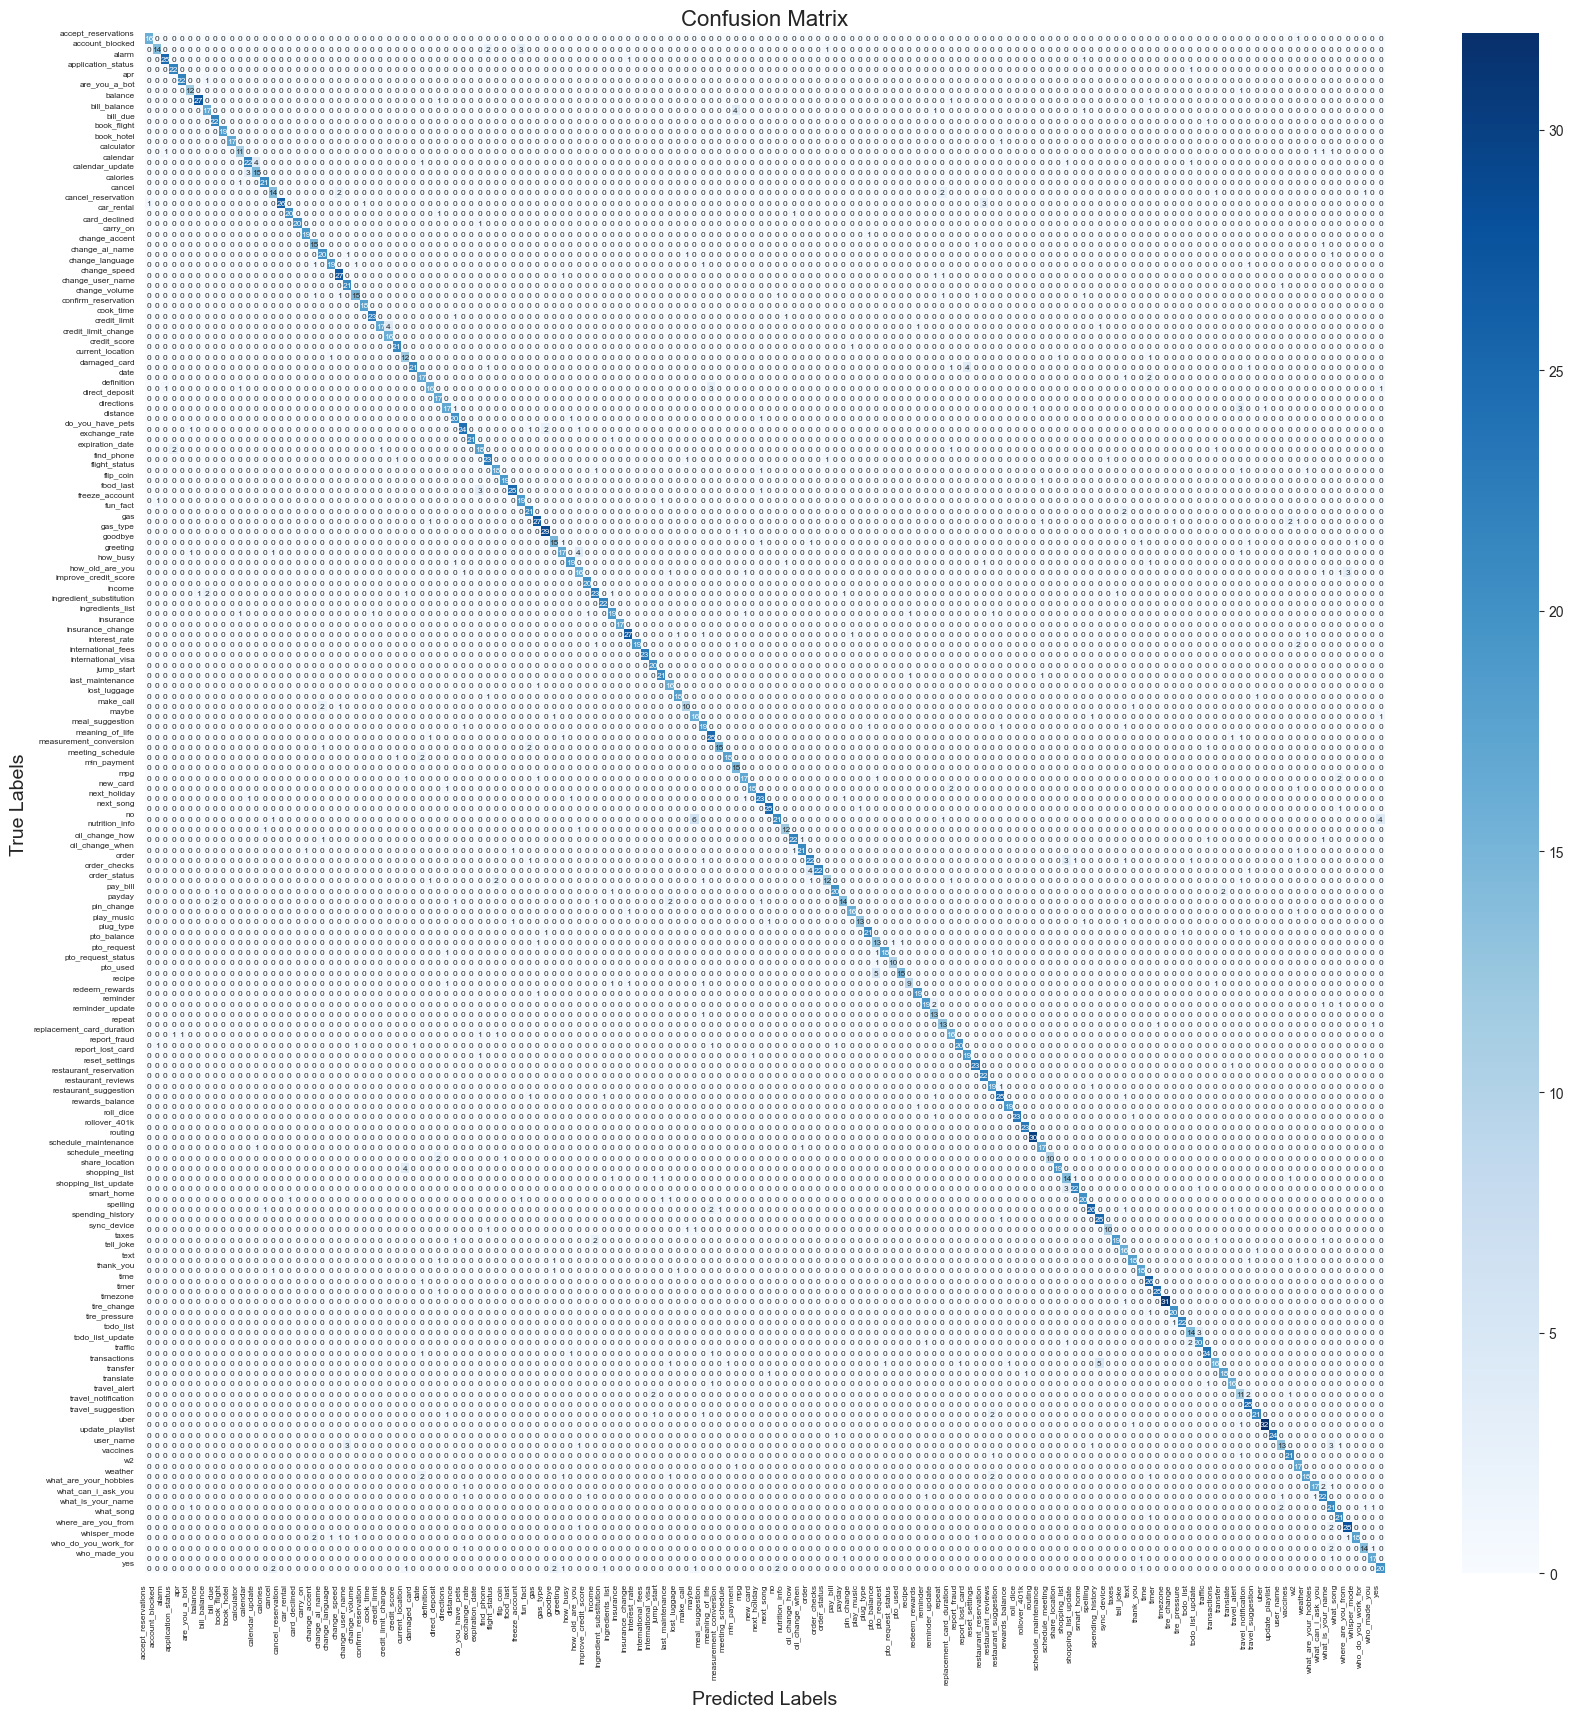

In [18]:
# Create the classifier
def create_classifier():
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=(1, 3),
            max_features=5000,
            min_df=2,
            use_idf=True,
            sublinear_tf=True
        )),
        ('classifier', MultinomialNB(alpha=0.1))
    ])

def main():
    
    X_train, y_train, X_val, y_val = load_data()
    
    feature_extractor = FeatureExtractor()
    
    print("Preprocessing training data...")
    X_train_processed = [feature_extractor.preprocess_text(text) for text in X_train]
    
    print("Preprocessing validation data...")
    X_val_processed = [feature_extractor.preprocess_text(text) for text in X_val]
    
    print("Training classifier...")
    classifier = create_classifier()
    classifier.fit(X_train_processed, y_train)
    
    print("Making predictions...")
    y_pred = classifier.predict(X_val_processed)
    
    unique_labels = sorted(set(y_train))
    plot_confusion_matrix(y_val, y_pred, unique_labels, "multinomialnb_confusion_matrix.pdf")
            
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
            
    multinomialnb_f1 = f1_score(y_val, y_pred, average='macro')
    multinomialnb_accuracy = accuracy_score(y_val, y_pred)
    multinomialnb_precision = precision_score(y_val, y_pred, average='macro')
    multinomialnb_recall = recall_score(y_val, y_pred, average='macro')
    
    multinomialnb_metrics = {
        'F1-Score': multinomialnb_f1,
        'Accuracy': multinomialnb_accuracy,
        'Precision': multinomialnb_precision,
        'Recall': multinomialnb_recall
    }
    
    return multinomialnb_metrics

if __name__ == "__main__":
    multinomialnb_metrics = main()

**2.1.4.2. tf-idf with Logistic Regression**

Preprocessing training data...
Preprocessing validation data...
Training classifier...
Making predictions...
Confusion matrix saved to logistic_regression_confusion_matrix.pdf

Classification Report:
                           precision    recall  f1-score   support

      accept_reservations       0.94      0.94      0.94        17
          account_blocked       0.89      0.80      0.84        20
                    alarm       1.00      0.96      0.98        27
       application_status       1.00      1.00      1.00        23
                      apr       1.00      0.91      0.95        23
            are_you_a_bot       0.76      1.00      0.87        13
                  balance       0.97      0.97      0.97        30
             bill_balance       0.91      0.91      0.91        23
                 bill_due       0.87      0.87      0.87        23
              book_flight       0.95      1.00      0.97        19
               book_hotel       0.89      0.94      0.92      

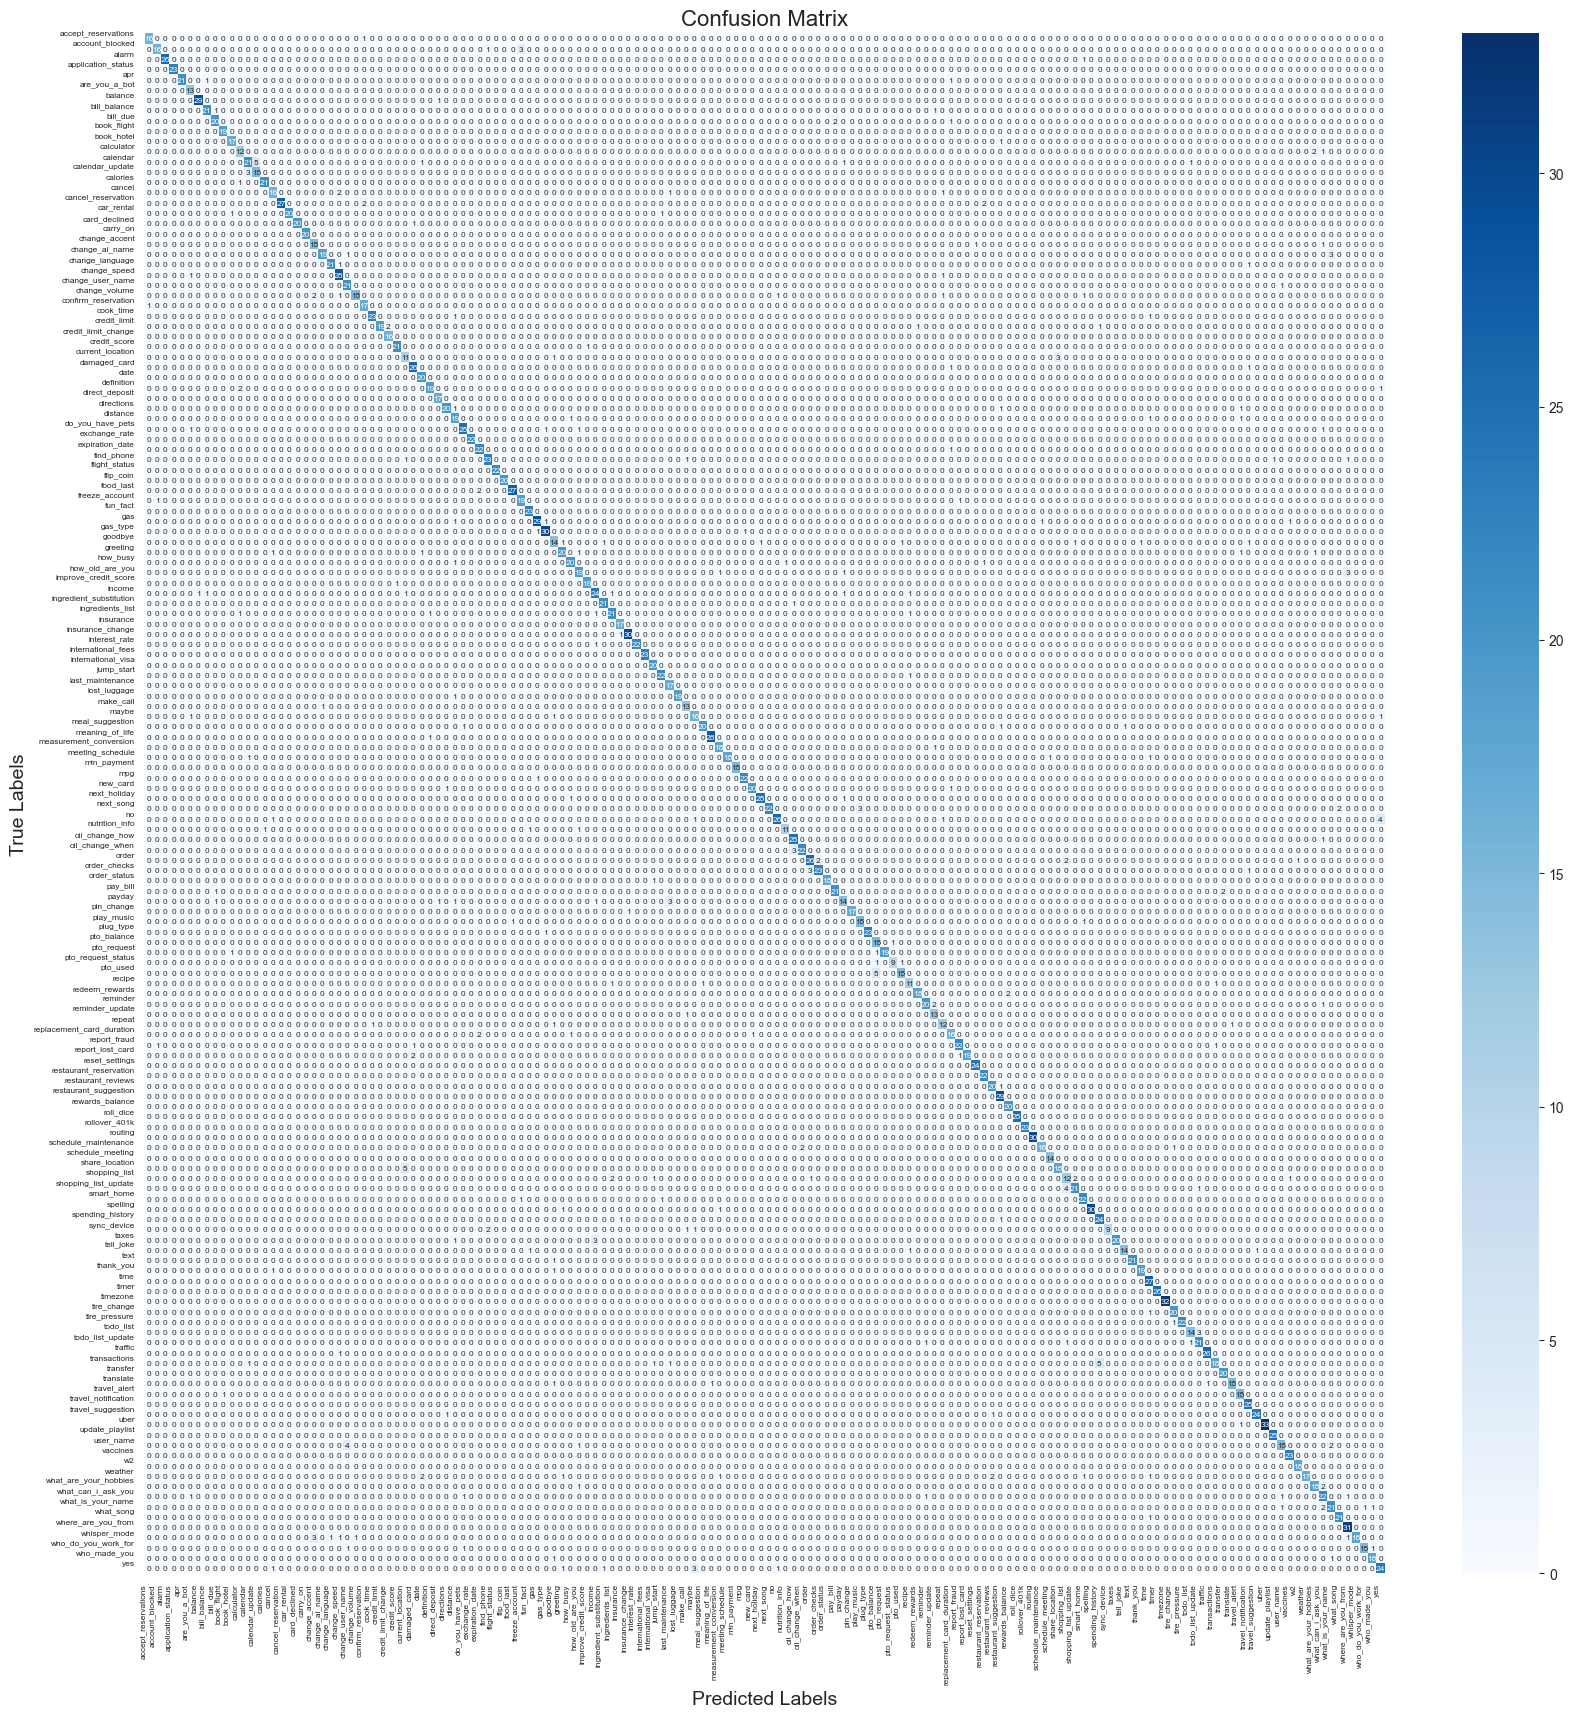

In [19]:
# Create classifier
def create_classifier():
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=(1, 3),
            max_features=5000,
            min_df=2,
            use_idf=True,
            sublinear_tf=True
        )),
        ('classifier', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))
    ])

def main():
    
    X_train, y_train, X_val, y_val = load_data()
    
    feature_extractor = FeatureExtractor()
    
    print("Preprocessing training data...")
    X_train_processed = [feature_extractor.preprocess_text(text) for text in X_train]
    print("Preprocessing validation data...")
    X_val_processed = [feature_extractor.preprocess_text(text) for text in X_val]
    
    print("Training classifier...")
    classifier = create_classifier()
    classifier.fit(X_train_processed, y_train)
    
    print("Making predictions...")
    y_pred = classifier.predict(X_val_processed)
    
    unique_labels = sorted(set(y_train))
    plot_confusion_matrix(y_val, y_pred, unique_labels, "logistic_regression_confusion_matrix.pdf")
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    logistic_regression_f1 = f1_score(y_val, y_pred, average='macro')
    logistic_regression_accuracy = accuracy_score(y_val, y_pred)
    logistic_regression_precision = precision_score(y_val, y_pred, average='macro')
    logistic_regression_recall = recall_score(y_val, y_pred, average='macro')
    
    logistic_regression_metrics = {
        'F1-Score': logistic_regression_f1,
        'Accuracy': logistic_regression_accuracy,
        'Precision': logistic_regression_precision,
        'Recall': logistic_regression_recall
    }
    
    return logistic_regression_metrics

if __name__ == "__main__":
    logistic_regression_metrics = main()

**2.1.4.3. tf-idf with SVM**

Preprocessing training data...
Preprocessing validation data...
Training classifier...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Making predictions...
Confusion matrix saved to svm_confusion_matrix.pdf

Classification Report:
                           precision    recall  f1-score   support

      accept_reservations       1.00      1.00      1.00        17
          account_blocked       0.89      0.85      0.87        20
                    alarm       1.00      1.00      1.00        27
       application_status       1.00      1.00      1.00        23
                      apr       1.00      0.96      0.98        23
            are_you_a_bot       1.00      0.92      0.96        13
                  balance       1.00      0.97      0.98        30
             bill_balance       0.92      0.96      0.94        23
                 bill_due       0.92      1.00      0.96        23
              book_flight       1.00      1.00      1.00        19
               book_hotel       0.94      0.94      0.94        18
               calculator       0.93      0.87      0.90        15
                 calendar      

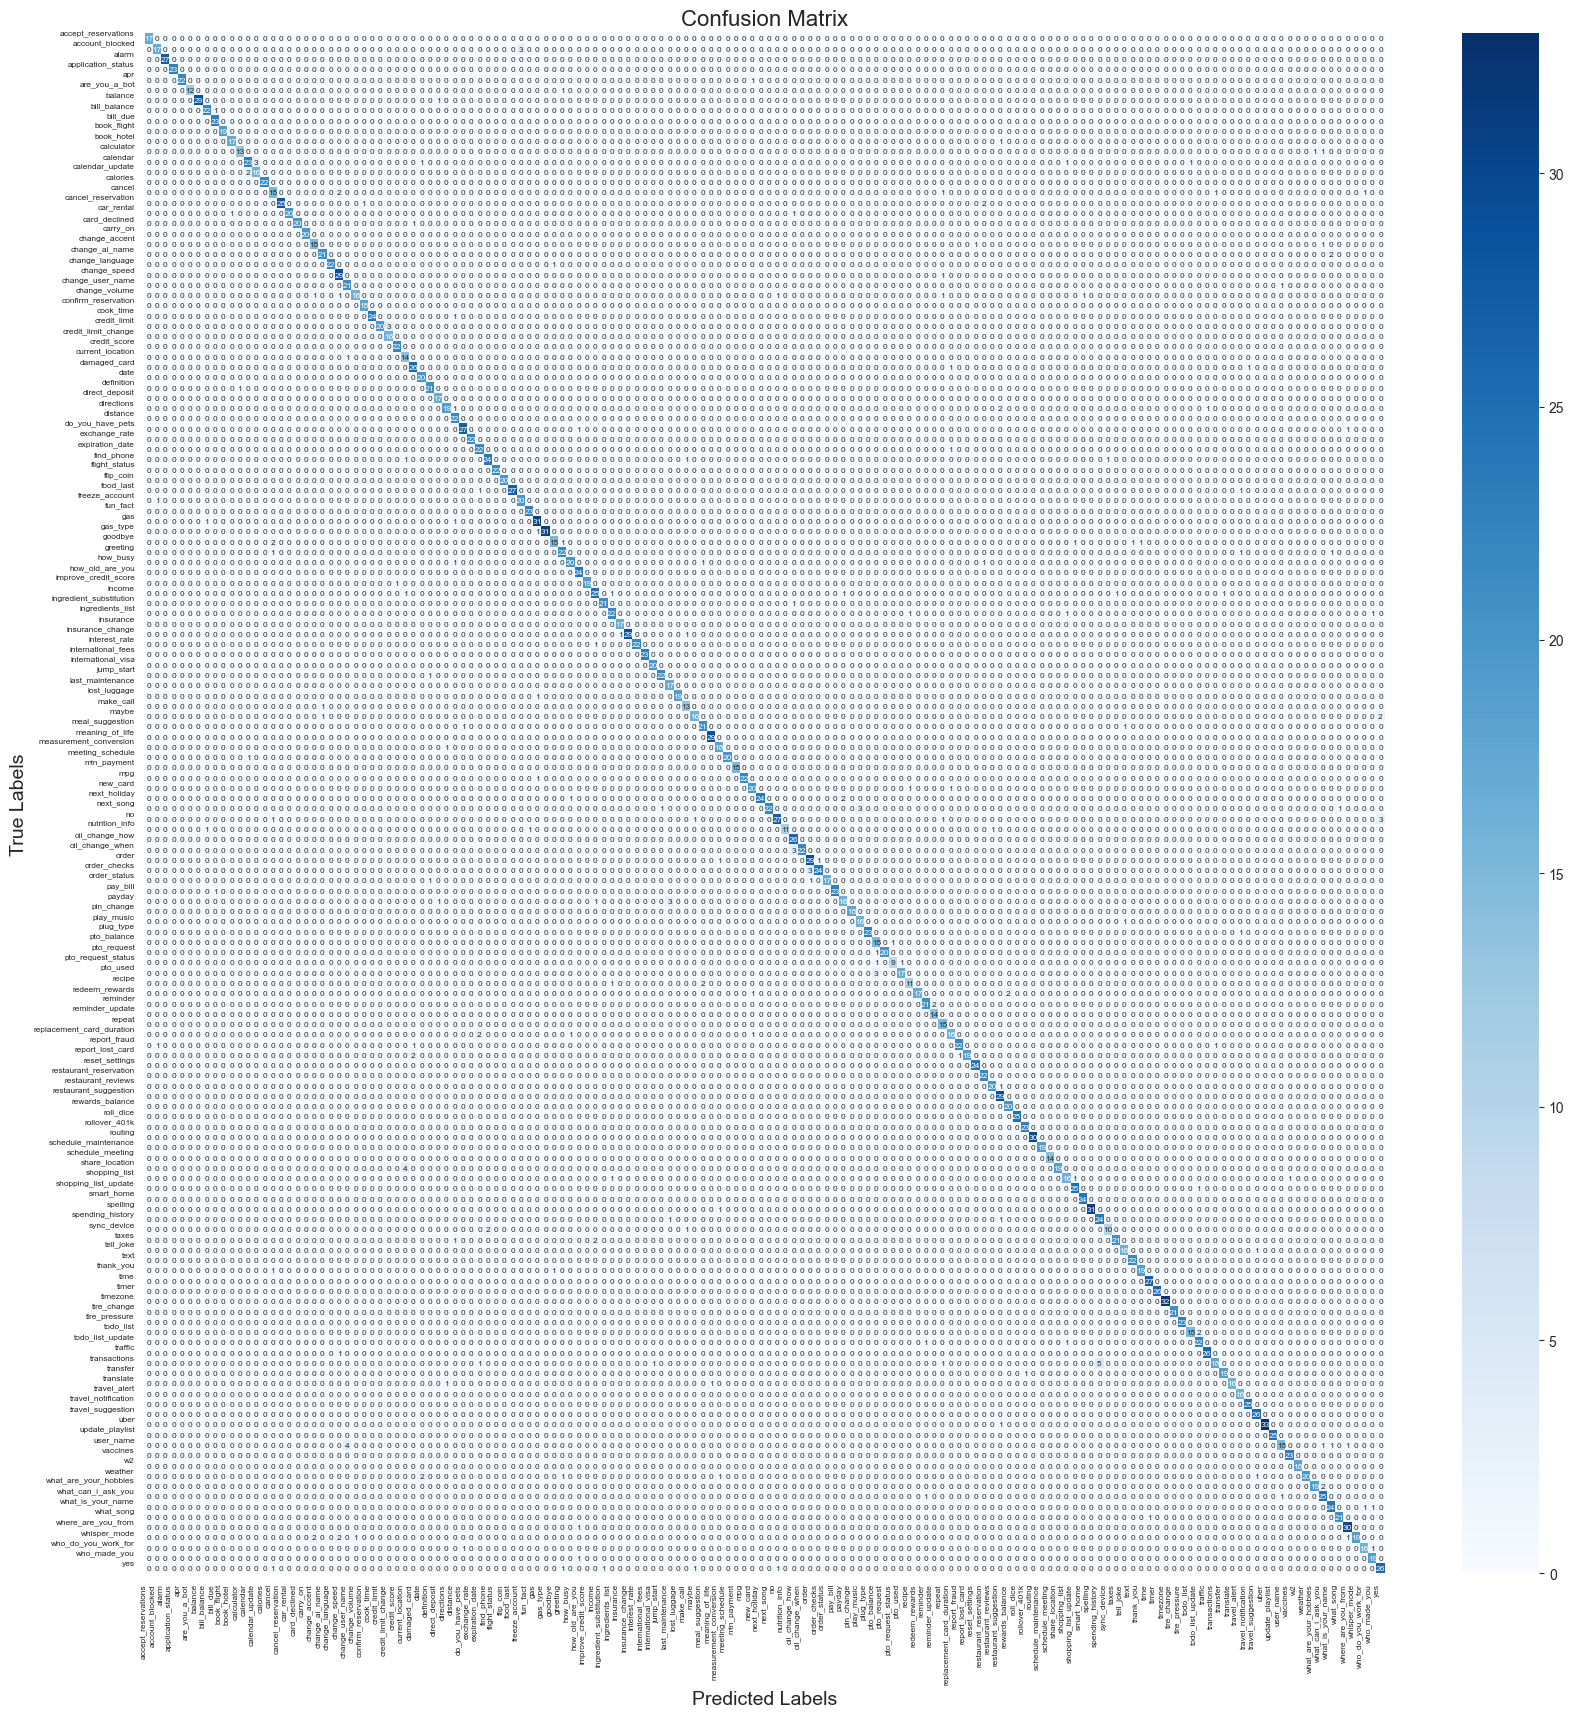

In [20]:
# Create SVM classifier
def create_classifier():
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=(1, 3),
            max_features=5000,
            min_df=2,
            use_idf=True,
            sublinear_tf=True
        )),
        ('classifier', LinearSVC())
    ])

def main():
    
    X_train, y_train, X_val, y_val = load_data()
    
    feature_extractor = FeatureExtractor()
    
    print("Preprocessing training data...")
    X_train_processed = [feature_extractor.preprocess_text(text) for text in X_train]
    print("Preprocessing validation data...")
    X_val_processed = [feature_extractor.preprocess_text(text) for text in X_val]
    
    print("Training classifier...")
    classifier = create_classifier()
    classifier.fit(X_train_processed, y_train)
    
    print("Making predictions...")
    y_pred = classifier.predict(X_val_processed)
    
    unique_labels = sorted(set(y_train))
    plot_confusion_matrix(y_val, y_pred, unique_labels, "svm_confusion_matrix.pdf")
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))

    svm_f1 = f1_score(y_val, y_pred, average='macro')
    svm_accuracy = accuracy_score(y_val, y_pred)
    svm_precision = precision_score(y_val, y_pred, average='macro')
    svm_recall = recall_score(y_val, y_pred, average='macro')
    
    svm_metrics = {
        'F1-Score': svm_f1,
        'Accuracy': svm_accuracy,
        'Precision': svm_precision,
        'Recall': svm_recall
    }
    
    return svm_metrics


if __name__ == "__main__":
    svm_metrics = main()

**2.1.4.4. tf-idf with Random Forest**

Preprocessing training data...
Preprocessing validation data...
Training classifier...
Making predictions...
Confusion matrix saved to random_forest_confusion_matrix.pdf

Classification Report:
                           precision    recall  f1-score   support

      accept_reservations       1.00      1.00      1.00        17
          account_blocked       0.84      0.80      0.82        20
                    alarm       1.00      0.96      0.98        27
       application_status       1.00      1.00      1.00        23
                      apr       1.00      0.91      0.95        23
            are_you_a_bot       0.67      0.77      0.71        13
                  balance       0.90      0.87      0.88        30
             bill_balance       0.91      0.87      0.89        23
                 bill_due       0.90      0.78      0.84        23
              book_flight       0.86      1.00      0.93        19
               book_hotel       0.90      1.00      0.95        18
 

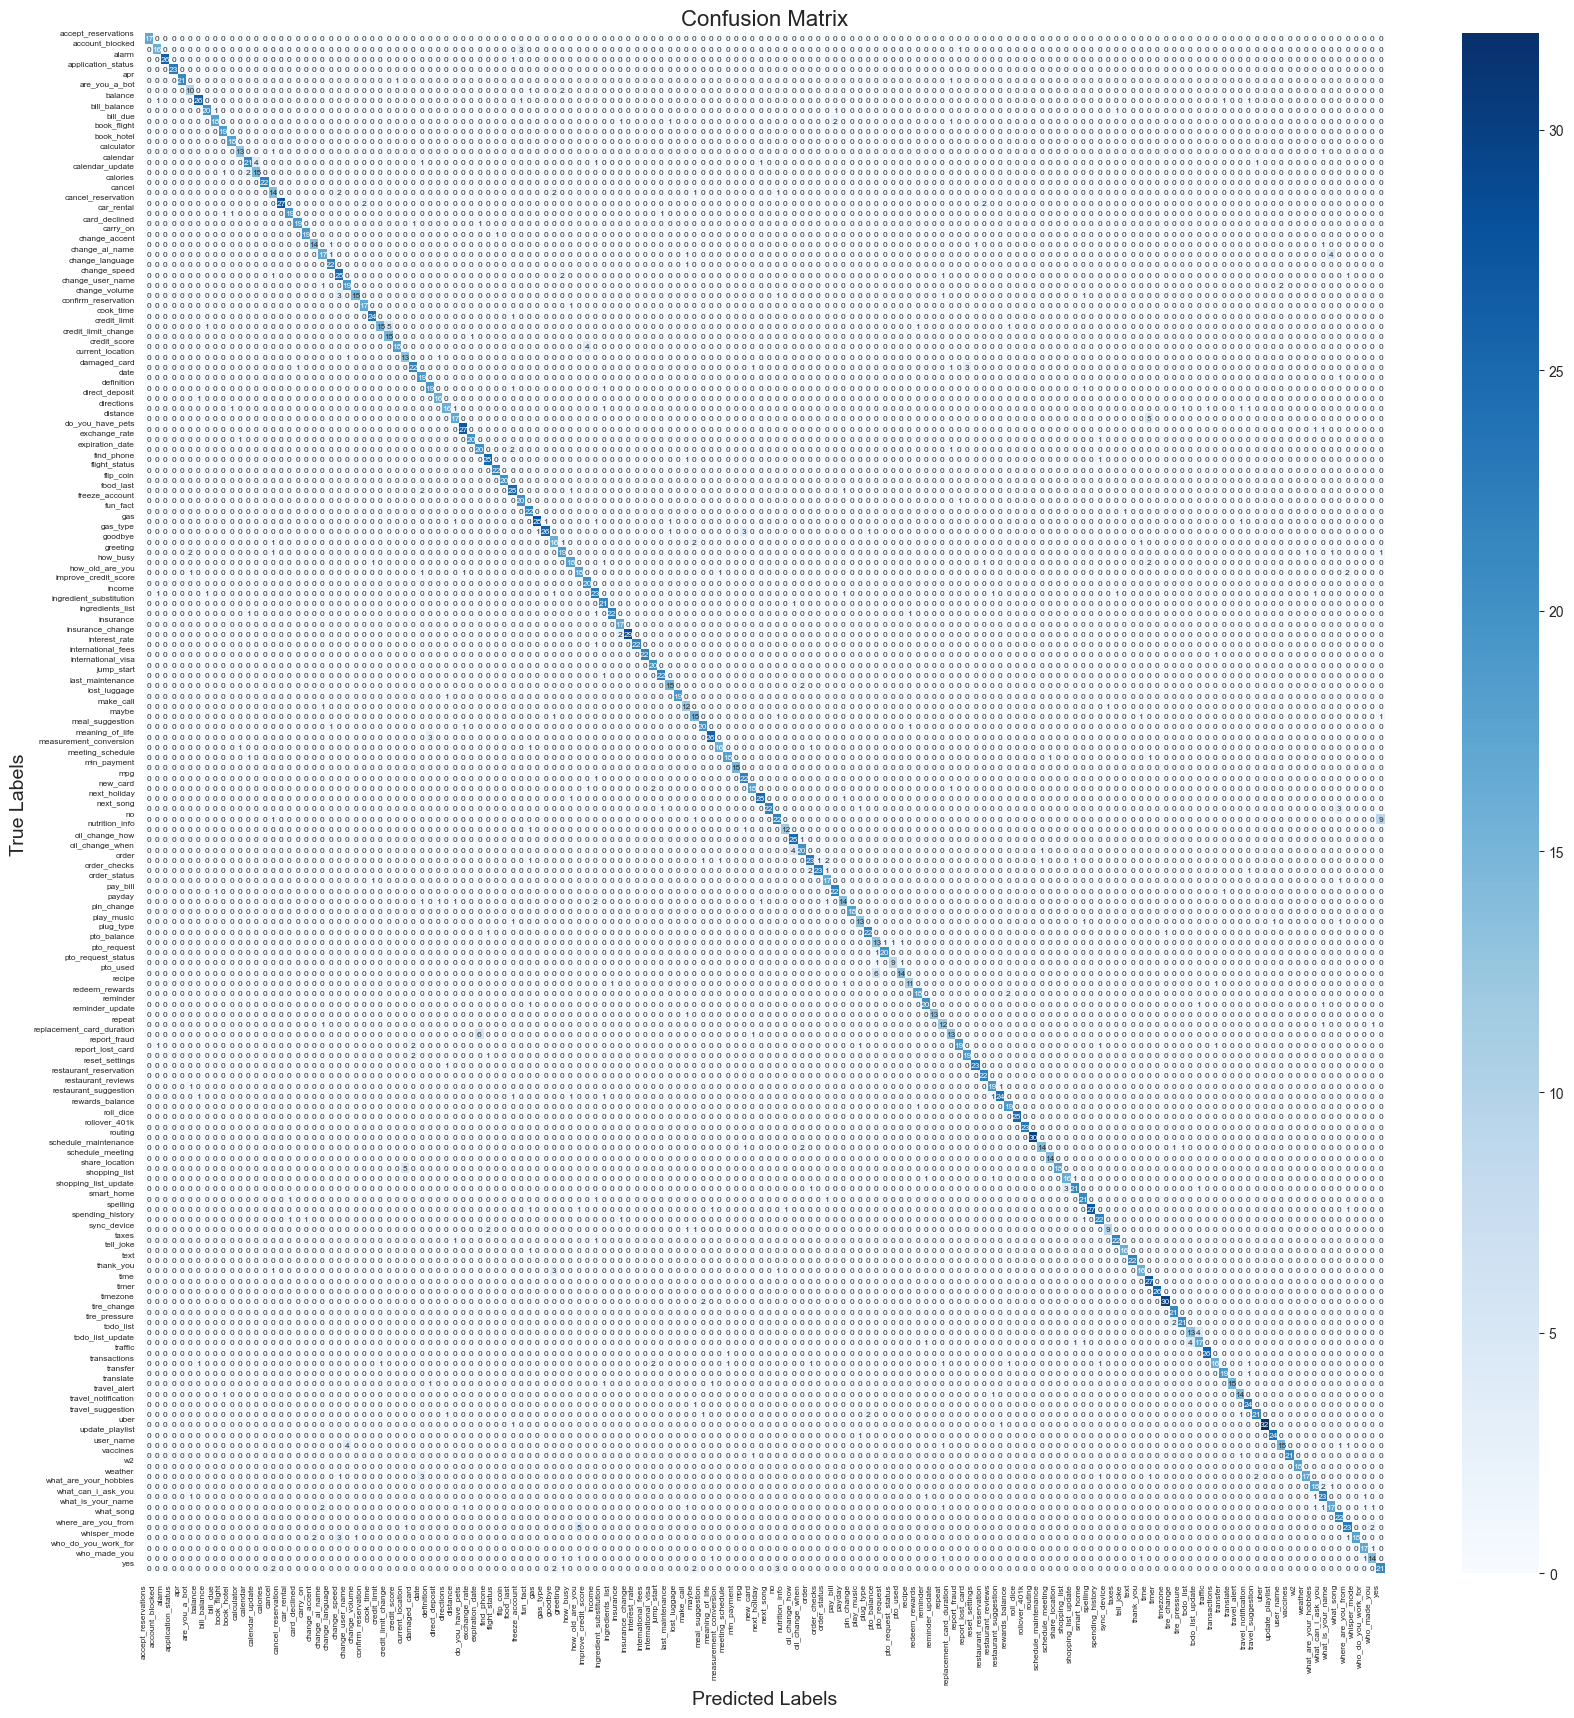

In [21]:
# Create random forest classifier
def create_classifier():
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=(1, 3),
            max_features=5000,
            min_df=2,
            use_idf=True,
            sublinear_tf=True
        )),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

def main():
    
    X_train, y_train, X_val, y_val = load_data()
    
    feature_extractor = FeatureExtractor()
    
    print("Preprocessing training data...")
    X_train_processed = [feature_extractor.preprocess_text(text) for text in X_train]
    print("Preprocessing validation data...")
    X_val_processed = [feature_extractor.preprocess_text(text) for text in X_val]
    
    print("Training classifier...")
    classifier = create_classifier()
    classifier.fit(X_train_processed, y_train)
    
    print("Making predictions...")
    y_pred = classifier.predict(X_val_processed)

    
    unique_labels = sorted(set(y_train))
    plot_confusion_matrix(y_val, y_pred, unique_labels, "random_forest_confusion_matrix.pdf")
    
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    
    random_forest_f1 = f1_score(y_val, y_pred, average='macro')
    random_forest_accuracy = accuracy_score(y_val, y_pred)
    random_forest_precision = precision_score(y_val, y_pred, average='macro')
    random_forest_recall = recall_score(y_val, y_pred, average='macro')
    
    random_forest_metrics = {
        'F1-Score': random_forest_f1,
        'Accuracy': random_forest_accuracy,
        'Precision': random_forest_precision,
        'Recall': random_forest_recall
    }
    
    return random_forest_metrics


if __name__ == "__main__":
    random_forest_metrics = main()

### 2.2. BERT Classifier

#### 2.2.1. Import libraries

In [23]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import classification_report, confusion_matrix

#### 2.2.2. Define an intent detection class 

In [24]:
#class to define the train val test datasets more clearly
class IntentDataset(Dataset):
    
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

#### 2.2.3. Define utility functions

In [25]:
#function to load the data from path
def load_data():
    #get train data json
    with open('Files/train_data.json', 'r') as file:
        train_data = json.load(file)
    
    #get val data json
    with open('Files/val_data.json', 'r') as file:
        val_data = json.load(file)
    
    X_train = [text for text, _ in train_data['train']]
    y_train = [intent for _, intent in train_data['train']]
    
    X_val = [text for text, _ in val_data['train']]
    y_val = [intent for _, intent in val_data['train']]
    
    #creating label encoding
    unique_labels = sorted(set(y_train))
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    id_to_label = {idx: label for label, idx in label_to_id.items()}
    
    #converitng labels to indices
    y_train = [label_to_id[label] for label in y_train]
    y_val = [label_to_id[label] for label in y_val]
    
    return X_train, y_train, X_val, y_val, label_to_id, id_to_label

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

#function to train by epochs for BERT
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    
    for batch in tqdm(data_loader, desc="Training"):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return total_loss / len(data_loader)

#evaluation function for BERT
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return predictions, true_labels

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\aydin\Desktop\NLP_Proje\nlp_venv\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/2


Training: 100%|██████████| 985/985 [17:16<00:00,  1.05s/it]


Average training loss: 3.5219


Evaluating: 100%|██████████| 211/211 [02:04<00:00,  1.69it/s]
c:\Users\aydin\Desktop\NLP_Proje\nlp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aydin\Desktop\NLP_Proje\nlp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aydin\Desktop\NLP_Proje\nlp_venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Validation Accuracy: 0.8711

Classification Report:
                           precision    recall  f1-score   support

      accept_reservations       0.88      0.82      0.85        17
          account_blocked       0.82      0.90      0.86        20
                    alarm       0.77      1.00      0.87        27
       application_status       1.00      0.70      0.82        23
                      apr       1.00      0.91      0.95        23
            are_you_a_bot       1.00      1.00      1.00        13
                  balance       0.96      0.83      0.89        30
             bill_balance       0.83      0.43      0.57        23
                 bill_due       0.95      0.87      0.91        23
              book_flight       1.00      1.00      1.00        19
               book_hotel       0.95      1.00      0.97        18
               calculator       1.00      0.87      0.93        15
                 calendar       1.00      0.66      0.79        29
         

Training: 100%|██████████| 985/985 [15:53<00:00,  1.03it/s]


Average training loss: 1.0951


Evaluating: 100%|██████████| 211/211 [01:45<00:00,  1.99it/s]


Validation Accuracy: 0.9662

Classification Report:
                           precision    recall  f1-score   support

      accept_reservations       1.00      1.00      1.00        17
          account_blocked       1.00      0.90      0.95        20
                    alarm       1.00      1.00      1.00        27
       application_status       1.00      1.00      1.00        23
                      apr       0.92      0.96      0.94        23
            are_you_a_bot       1.00      1.00      1.00        13
                  balance       0.97      0.97      0.97        30
             bill_balance       0.88      1.00      0.94        23
                 bill_due       1.00      0.96      0.98        23
              book_flight       1.00      1.00      1.00        19
               book_hotel       1.00      1.00      1.00        18
               calculator       1.00      0.93      0.97        15
                 calendar       0.97      0.97      0.97        29
         

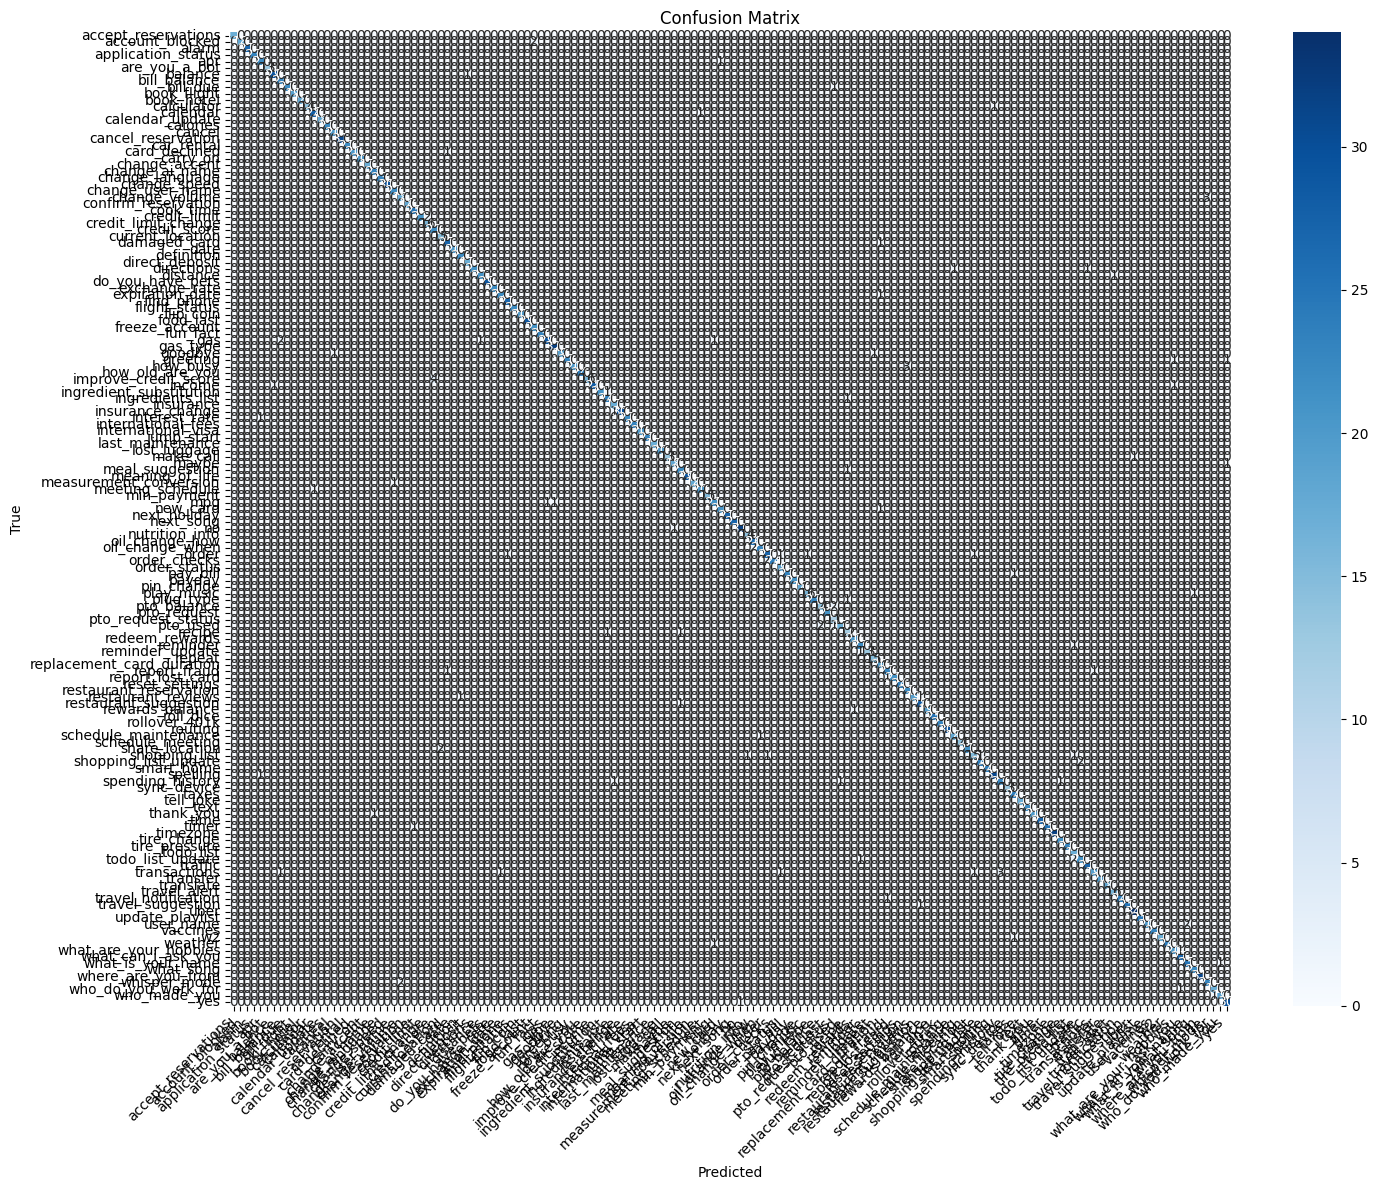

In [ ]:
#BERT main
def main():
   
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    #Load data
    X_train, y_train, X_val, y_val, label_to_id, id_to_label = load_data()
    num_labels = len(label_to_id)
    
    #tokenizer and model
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=num_labels
    ).to(device)
    
    #datasets
    train_dataset = IntentDataset(X_train, y_train, tokenizer)
    val_dataset = IntentDataset(X_val, y_val, tokenizer)
    
    #data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)

    optimizer = AdamW(model.parameters(), lr=2e-5)
    
    #training
    num_epochs = 2
    best_accuracy = 0
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        avg_loss = train_epoch(model, train_loader, optimizer, device)
        print(f"Average training loss: {avg_loss:.4f}")
        

        predictions, true_labels = evaluate(model, val_loader, device)
        
        # convert to text labels
        pred_labels = [id_to_label[p] for p in predictions]
        true_labels = [id_to_label[t] for t in true_labels]
        
        accuracy = accuracy_score(pred_labels, true_labels)
        print(f"Validation Accuracy: {accuracy:.4f}")
        
        
        print("\nClassification Report:")
        print(classification_report(true_labels, pred_labels))
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            # save best model
            torch.save(model.state_dict(), 'bert_intent_classifier.pt')
    
    #confusion matrix for best model
    plot_confusion_matrix(true_labels, pred_labels, sorted(label_to_id.keys()))
    
    #metrics
    bert_f1 = f1_score(true_labels, pred_labels, average='macro')
    bert_accuracy = accuracy_score(true_labels, pred_labels)
    bert_precision = precision_score(true_labels, pred_labels, average='macro')
    bert_recall = recall_score(true_labels, pred_labels, average='macro')
    
    bert_metrics = {
        'F1-Score': bert_f1,
        'Accuracy': bert_accuracy,
        'Precision': bert_precision,
        'Recall': bert_recall
    }
    
    return bert_metrics


if __name__ == "__main__":
    bert_metrics = main()

### 2.3 Ensemble

#### 2.3.1 Libraries

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification,
    AdamW
)
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                        precision_recall_curve, average_precision_score) 
from sklearn.preprocessing import LabelEncoder
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import List, Dict, Tuple
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import copy
import os
import pickle
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification



c:\Users\aydin\Desktop\NLP_Proje\nlp_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2.3.2.Intent class for ensemble method

In [7]:
#dataset for the use of ensemble BERT model (altered form BERT)
class IntentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, label_encoder, max_length=128):
        self.texts = texts
        self.labels = label_encoder.transform(labels)  # Convert string labels to numeric indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


#### 2.3.3 Ensemble Model class

In [5]:
#ensemble model class to handle the functionalities
class EnsembleModel:
    def __init__(self, num_labels: int, device: torch.device):
        self.models = {
            'bert': (
                BertTokenizer.from_pretrained('bert-base-uncased'),
                BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
            ),
            'roberta': (
                RobertaTokenizer.from_pretrained('roberta-base'),
                RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=num_labels)
            ),
            'distilbert': (
                DistilBertTokenizer.from_pretrained('distilbert-base-uncased'),
                DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)
            )
        }
        
        self.device = device
        for model_name, (_, model) in self.models.items():
            model.to(device)
        
        self.optimizers = {
            model_name: AdamW(model.parameters(), lr=2e-5)
            for model_name, (_, model) in self.models.items()
        }
    #train function -> returns losses
    def train_epoch(self, data: Dict[str, DataLoader]) -> Dict[str, float]:
        losses = {}
        for model_name, (_, model) in self.models.items():
            model.train()
            total_loss = 0
            
            for batch in tqdm(data[model_name], desc=f"Training {model_name}"):
                self.optimizers[model_name].zero_grad()
                
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                
                loss = outputs.loss
                total_loss += loss.item()
                
                loss.backward()
                self.optimizers[model_name].step()
            
            losses[model_name] = total_loss / len(data[model_name])
        
        return losses
    
    #prediction funtion -> returns labels, predictions and probabilities 
    def predict(self, data: Dict[str, DataLoader], weights: Dict[str, float] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        if weights is None:
            weights = {model_name: 1/len(self.models) for model_name in self.models.keys()}
        
        all_predictions = []
        all_true_labels = []
        
        for model_name, (_, model) in self.models.items():
            model.eval()
            predictions = []
            true_labels = []
            
            with torch.no_grad():
                for batch in tqdm(data[model_name], desc=f"Evaluating {model_name}"):
                    input_ids = batch['input_ids'].to(self.device)
                    attention_mask = batch['attention_mask'].to(self.device)
                    labels = batch['labels'].to(self.device)
                    
                    outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                    )
                    
                    logits = outputs.logits * weights[model_name]
                    predictions.append(logits.cpu())
                    true_labels.extend(labels.cpu().numpy())
            
            all_predictions.append(torch.cat(predictions))
            if not all_true_labels:
                all_true_labels = true_labels
        
        ensemble_predictions = torch.stack(all_predictions).sum(dim=0)
        
        probabilities = torch.softmax(ensemble_predictions, dim=1).numpy()
        final_predictions = np.argmax(probabilities, axis=1)
        
        return final_predictions, all_true_labels, probabilities



#### 2.3.4 Utility functions

In [6]:
#loading data
def load_data():
    # Load training data
    with open('Files/train_data.json', 'r') as file:
        train_data = json.load(file)
    
    # Load validation data (for testing)
    with open('Files/val_data.json', 'r') as file:
        val_data = json.load(file)
    
    # Extract texts and labels
    X_train = [text for text, _ in train_data['train']]
    y_train = [intent for _, intent in train_data['train']]
    
    X_val = [text for text, _ in val_data['train']]
    y_val = [intent for _, intent in val_data['train']]
    
    return X_train, y_train, X_val, y_val

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    

#function to save the best model to the system to
#use it when evaluating for the test
def save_ensemble_model(ensemble, label_encoder, save_dir='saved_models'):

    os.makedirs(save_dir, exist_ok=True)
    model_config = {
        'model_states': {},
        'model_configs': {},
        'tokenizer_names': {}
    }
    
    for model_name, (tokenizer, model) in ensemble.models.items():
        model_config['model_states'][model_name] = model.state_dict()
        
        model_config['model_configs'][model_name] = model.config.to_dict()
        
        model_config['tokenizer_names'][model_name] = tokenizer.__class__.__name__

    torch.save(model_config, os.path.join(save_dir, 'ensemble_config.pt'))
    
    with open(os.path.join(save_dir, 'label_encoder.pkl'), 'wb') as f:
        pickle.dump(label_encoder, f)



#### 2.3.5. Ensemble Main

In [ ]:
#min for ensemble
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    X_train, y_train, X_val, y_val = load_data()
    
    label_encoder = LabelEncoder()
    label_encoder.fit(y_train + y_val)  # Fit on all labels
    
    num_labels = len(label_encoder.classes_)
    print(f"Number of unique intents: {num_labels}")
    
    # initialize ensemble
    ensemble = EnsembleModel(num_labels, device)
    
    #create datasets and dataloaders for each model
    train_loaders = {}
    val_loaders = {}
    
    for model_name, (tokenizer, _) in ensemble.models.items():
        train_dataset = IntentDataset(X_train, y_train, tokenizer, label_encoder)
        val_dataset = IntentDataset(X_val, y_val, tokenizer, label_encoder)
        
        train_loaders[model_name] = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loaders[model_name] = DataLoader(val_dataset, batch_size=16)
    
    # training loop with parameters
    num_epochs = 2
    best_accuracy = 0
    model_weights = {
        'bert': 0.3,
        'roberta': 0.5,
        'distilbert': 0.2
    }
    
    best_model_states = {}
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        
        losses = ensemble.train_epoch(train_loaders)
        for model_name, loss in losses.items():
            print(f"Average {model_name} training loss: {loss:.4f}")
        
        predictions, true_labels, _ = ensemble.predict(val_loaders, weights=model_weights)
        
        pred_labels = label_encoder.inverse_transform(predictions)
        true_labels = label_encoder.inverse_transform(true_labels)
        
        accuracy = accuracy_score(pred_labels, true_labels)
        print(f"Ensemble Validation Accuracy: {accuracy:.4f}")
        
        print("\nClassification Report:")
        print(classification_report(true_labels, pred_labels))
        
        # save best models
        if accuracy > best_accuracy:
            print(f"New best accuracy: {accuracy:.4f}")
            best_accuracy = accuracy
            
            # store the best ensemble state
            best_ensemble = copy.deepcopy(ensemble)
    
    # save the complete best model
    print("\nSaving best ensemble model...")
    try:
        save_ensemble_model(best_ensemble, label_encoder)
        print("Model saved successfully to 'saved_models' directory!")
    except Exception as e:
        print(f"Error saving model: {str(e)}")
    
    ensemble_f1 = f1_score(true_labels, pred_labels, average='macro')
    ensemble_accuracy = accuracy_score(true_labels, pred_labels)
    ensemble_precision = precision_score(true_labels, pred_labels, average='macro')
    ensemble_recall = recall_score(true_labels, pred_labels, average='macro')
    
    ensemble_metrics = {
        'F1-Score': ensemble_f1,
        'Accuracy': ensemble_accuracy,
        'Precision': ensemble_precision,
        'Recall': ensemble_recall
    }
    
    return ensemble_metrics

if __name__ == "__main__":
    main()

Using device: cuda
Number of unique intents: 150


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe


Epoch 1/2


Training distilbert: 100%|██████████| 985/985 [01:57<00:00,  8.41it/s]


Average bert training loss: 3.3754
Average roberta training loss: 2.5082
Average distilbert training loss: 3.0422


Evaluating distilbert: 100%|██████████| 211/211 [00:13<00:00, 15.92it/s]


Ensemble Validation Accuracy: 0.9553

Classification Report:
                           precision    recall  f1-score   support

      accept_reservations       0.94      1.00      0.97        17
          account_blocked       1.00      0.90      0.95        20
                    alarm       1.00      1.00      1.00        27
       application_status       1.00      1.00      1.00        23
                      apr       0.95      0.91      0.93        23
            are_you_a_bot       1.00      1.00      1.00        13
                  balance       0.97      0.97      0.97        30
             bill_balance       0.96      1.00      0.98        23
                 bill_due       1.00      1.00      1.00        23
              book_flight       1.00      1.00      1.00        19
               book_hotel       1.00      1.00      1.00        18
               calculator       1.00      0.93      0.97        15
                 calendar       0.95      0.72      0.82        29


Training distilbert: 100%|██████████| 985/985 [20:43<00:00,  1.26s/it]


Average bert training loss: 0.9950
Average roberta training loss: 0.3951
Average distilbert training loss: 0.5461


Evaluating distilbert: 100%|██████████| 211/211 [00:24<00:00,  8.46it/s]


Ensemble Validation Accuracy: 0.9796

Classification Report:
                           precision    recall  f1-score   support

      accept_reservations       1.00      1.00      1.00        17
          account_blocked       1.00      0.90      0.95        20
                    alarm       1.00      1.00      1.00        27
       application_status       1.00      1.00      1.00        23
                      apr       1.00      1.00      1.00        23
            are_you_a_bot       1.00      1.00      1.00        13
                  balance       0.97      0.97      0.97        30
             bill_balance       1.00      1.00      1.00        23
                 bill_due       1.00      1.00      1.00        23
              book_flight       1.00      1.00      1.00        19
               book_hotel       1.00      1.00      1.00        18
               calculator       1.00      0.93      0.97        15
                 calendar       0.96      0.90      0.93        29


## 3. Compare classifiers

In [29]:
import pandas as pd

metrics_data = {
    'MultinomialNB': multinomialnb_metrics,
    'Logistic Regression': logistic_regression_metrics,
    'SVM': svm_metrics,
    'Random Forest': random_forest_metrics,
    'BERT': bert_metrics
}

metrics_df = pd.DataFrame(metrics_data)

metrics_df = metrics_df.transpose()
print(metrics_df)

metrics_df.to_csv('metrics_comparison.csv', index=True)

                     F1-Score  Accuracy  Precision    Recall
MultinomialNB        0.850803  0.853333   0.855751  0.854388
Logistic Regression  0.895846  0.898963   0.899405  0.897972
SVM                  0.928290  0.930370   0.931404  0.929769
Random Forest        0.863808  0.864593   0.867927  0.866671
BERT                 0.965247  0.966222   0.966030  0.966542


## 4. SVM vs BERT

### 4.1. Ensemble BERT

#### 4.1.1. Functions for the ensemble testing

In [8]:
def load_test_data():
    with open('Files/test_data.json', 'r') as file:
        test_data = json.load(file)
    print("opened test")

    X_test = [text for text, _ in test_data['train']]
    y_test = [intent for _, intent in test_data['train']]
    print("X y ayrildi")
    return X_test, y_test

def create_test_dataloaders(X_test, y_test, ensemble, label_encoder, max_length=128):
    test_loaders = {}
    
    for model_name, (tokenizer, _) in ensemble.models.items():
        test_dataset = IntentDataset(
            texts=X_test,
            labels=y_test,
            tokenizer=tokenizer,
            label_encoder=label_encoder,
            max_length=max_length
        )
        test_loaders[model_name] = DataLoader(test_dataset, batch_size=16)
    
    return test_loaders

#evaluation function
def evaluate_ensemble(ensemble, test_loaders, label_encoder):
    model_weights = {
        'bert': 0.3,
        'roberta': 0.5,
        'distilbert': 0.2
    }
    
    predictions, true_labels, probabilities = ensemble.predict(test_loaders, weights=model_weights)
    
    pred_labels = label_encoder.inverse_transform(predictions)
    true_labels = label_encoder.inverse_transform(true_labels)
    
    return pred_labels, true_labels, probabilities


# function to load the saved best ensemble model for the testing
def load_ensemble_model(load_dir='saved_models'):

    model_config = torch.load(os.path.join(load_dir, 'ensemble_config.pt'))
    
    with open(os.path.join(load_dir, 'label_encoder.pkl'), 'rb') as f:
        label_encoder = pickle.load(f)
    
    num_labels = len(label_encoder.classes_)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ensemble = EnsembleModel(num_labels, device)
    
    for model_name in model_config['model_states'].keys():
        base_model_name = {
            'bert': 'bert-base-uncased',
            'roberta': 'roberta-base',
            'distilbert': 'distilbert-base-uncased'
        }.get(model_name)
        
        config = model_config['model_configs'][model_name]
        
        model = AutoModelForSequenceClassification.from_pretrained(
            base_model_name,
            num_labels=num_labels,
            config=config
        )
        
        #load saved state
        model.load_state_dict(model_config['model_states'][model_name])
        model.to(device)
        
        #tokenizer
        tokenizer = AutoTokenizer.from_pretrained(base_model_name)
        
        ensemble.models[model_name] = (tokenizer, model)
    
    return ensemble, label_encoder



#### 4.1.2. Evaluating the test

In [13]:
#main function to test the ensemble model
def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    try:
        print("Loading saved model...")
        ensemble, label_encoder = load_ensemble_model()
        print("Model loaded successfully!")
        
        print("Loading test data...")
        X_test, y_test = load_test_data()
        print(f"Loaded {len(X_test)} test samples")
        
        test_loaders = create_test_dataloaders(X_test, y_test, ensemble, label_encoder)
        
        # evaluate model
        print("\nEvaluating model on test data...")
        pred_labels, true_labels, probabilities = evaluate_ensemble(ensemble, test_loaders, label_encoder)
        
        # print_metrics(true_labels, pred_labels, probabilities, label_encoder)
        
        results = classification_report(true_labels, pred_labels, output_dict=True)
        with open('test_results.json', 'w') as f:
            json.dump(results, f, indent=4)
        print("\nDetailed results saved to 'test_results.json'")
        
        
    except Exception as e:
        print(f"Error during testing: {str(e)}")

    return true_labels, pred_labels, probabilities, label_encoder.classes_, label_encoder
    
if __name__ == "__main__":
    result = main()

Using device: cuda
Loading saved model...


C:\Users\aydin\AppData\Local\Temp\ipykernel_31588\836951115.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_config = torch.load(os.path.join(load_dir, 'ensemble_c

Model loaded successfully!
Loading test data...
opened test
X y ayrildi
Loaded 3375 test samples

Evaluating model on test data...


Evaluating distilbert: 100%|██████████| 211/211 [00:08<00:00, 24.83it/s]



Detailed results saved to 'test_results.json'


#### 4.1.3. Plotting the results for Ensemble model

In [14]:

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.metrics import auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix



#confusion matrix for the most confused 20 classes
def plot_confusion_matrix_top_20(y_true, y_pred, labels, output_file):
    cm = confusion_matrix(y_true, y_pred)
    
    #most confused classes
    confusion_scores = cm.sum(axis=1) + cm.sum(axis=0) - 2 * np.diag(cm)
    top_20_indices = np.argsort(confusion_scores)[-20:]  #top 20 most confused classes
    
    cm_top_20 = cm[np.ix_(top_20_indices, top_20_indices)]
    top_20_labels = [labels[i] for i in top_20_indices]
    
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(
        cm_top_20,
        annot=True,
        annot_kws={"size": 8},
        cmap='Blues',
        xticklabels=top_20_labels,
        yticklabels=top_20_labels,
        cbar=True
    )
    
    ax.set_title('Confusion Matrix (Top 20 Most Confused Classes)', fontsize=16)
    ax.set_xlabel('Predicted Labels', fontsize=14)
    ax.set_ylabel('True Labels', fontsize=14)
    ax.set_xticklabels(top_20_labels, rotation=45, fontsize=10, ha='right')
    ax.set_yticklabels(top_20_labels, fontsize=10)
    
    # save as PDF
    with PdfPages(output_file) as pdf:
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
    
    print(f"Confusion matrix (top 20 most confused classes) saved to {output_file}")
    
    

# precision recall curve for ensemble
def plot_precision_recall_curves(y_true, y_scores, labels, output_file, label_encoder, y_pred):
    
    print(f"y_true: {y_true}")
    print(f"y_scores: {y_scores}")
    print(f"labels: {labels}")
    
    
    num_samples = len(y_true)
    num_classes = len(labels)
    lb = LabelBinarizer()

    y_true_onehot = lb.fit_transform(y_true)

    y_true_int = label_encoder.transform(y_true)
    print(f"y_true_int: {y_true_int}")
    print(f"y_true_onehot: {y_true_onehot}")
    print("max:", y_true_onehot.max())


    for idx, class_id in enumerate(y_true_int):
        if class_id >= num_classes:
            raise ValueError(f"Class ID {class_id} is out of bounds for the number of classes {num_classes}.")
        y_true_onehot[idx, class_id] = 1

    avg_precision_scores = []
    for i in range(num_classes):
        if np.sum(y_true_onehot[:, i]) > 0:
            precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_scores[:, i])
            auc_score = auc(recall, precision)
            avg_precision_scores.append(auc_score)
        else:
            avg_precision_scores.append(0.0)


    cm = confusion_matrix(y_true, y_pred)
    
    #most confused classes
    confusion_scores = cm.sum(axis=1) + cm.sum(axis=0) - 2 * np.diag(cm)
    top_20_indices = np.argsort(confusion_scores)[-20:]

    plt.figure(figsize=(10, 8))
    for i in top_20_indices:
        precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_scores[:, i])
        pr_auc = auc(recall, precision)
        plt.plot(
            recall,
            precision,
            lw=2,
            label=f"{label_encoder.classes_[i]} (AUC={pr_auc:.2f})"
        )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (Top 20 Classes)")
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize="small")
    plt.grid(alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.show()
    plt.close()
    print(f"Top 20 Precision-Recall Curves saved to {output_file}")
    




#### 4.1.4. Plotting the matrices

Plotting confusion matrix...
Confusion matrix (top 20 most confused classes) saved to confusion_matrix_top_20.pdf
Confusion matrix plot saved to confusion_matrix_top_20.pdf
Plotting precision-recall curves...
['timer' 'freeze_account' 'tell_joke' ... 'change_volume'
 'oil_change_when' 'replacement_card_duration']
y_true: ['timer' 'freeze_account' 'tell_joke' ... 'change_volume'
 'oil_change_when' 'replacement_card_duration']
y_scores: [[0.00041947 0.00031719 0.00325136 ... 0.00028151 0.00025513 0.00044825]
 [0.00031804 0.03060555 0.00049774 ... 0.00042459 0.00021081 0.00015931]
 [0.00030416 0.00030703 0.00028985 ... 0.00034004 0.00052041 0.00084269]
 ...
 [0.00042475 0.0001745  0.00080634 ... 0.00038795 0.00060345 0.00118016]
 [0.00022895 0.00024114 0.00067859 ... 0.00039003 0.00049198 0.0005125 ]
 [0.000441   0.00036472 0.00069799 ... 0.00051452 0.0003051  0.00035439]]
labels: ['accept_reservations' 'account_blocked' 'alarm' 'application_status'
 'apr' 'are_you_a_bot' 'balance' 'bill_

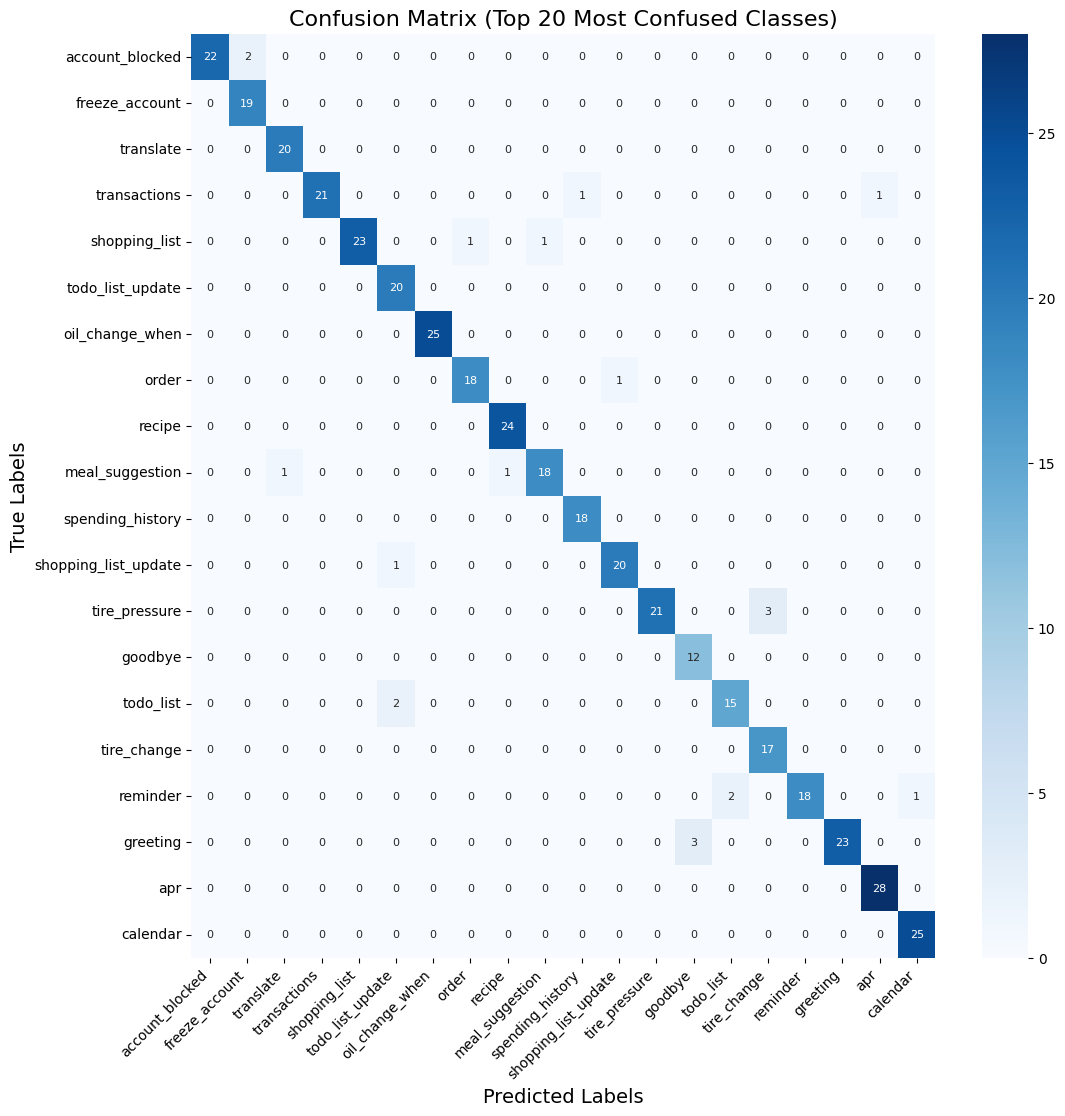

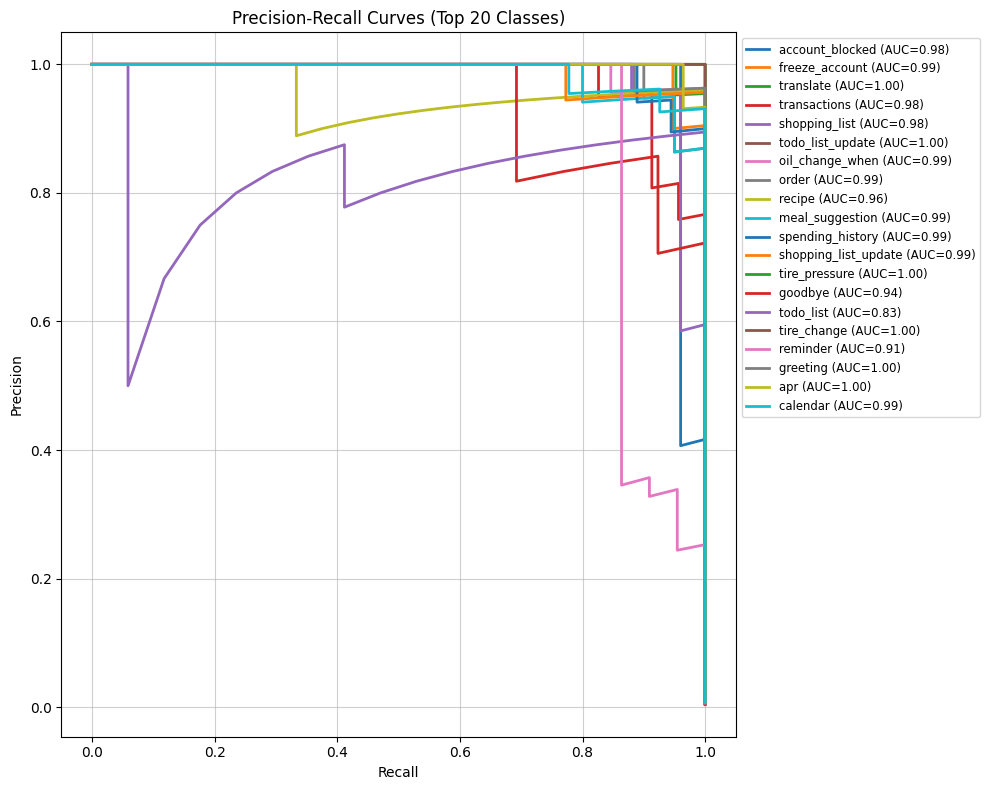

Top 20 Precision-Recall Curves saved to precision_recall_top_20.pdf
Precision-recall curves saved to precision_recall_top_20.pdf


In [15]:
true_labels, pred_labels, probabilities, labels, label_encoder = result

#confusion matrix plot
print("Plotting confusion matrix...")
confusion_matrix_output_file = "confusion_matrix_top_20.pdf"
plot_confusion_matrix_top_20(
    y_true=true_labels,
    y_pred=pred_labels,
    labels=labels,
    output_file=confusion_matrix_output_file
)
print(f"Confusion matrix plot saved to {confusion_matrix_output_file}")

#precision-recall curves
print("Plotting precision-recall curves...")
print(true_labels)
precision_recall_output_file = "precision_recall_top_20.pdf"
plot_precision_recall_curves(true_labels, probabilities, labels, precision_recall_output_file, label_encoder, pred_labels)
print(f"Precision-recall curves saved to {precision_recall_output_file}")


### 4.2. SVM with Hyperparameter Tuning

#### 4.2.1. Import necessary libraries for SVM and hyperparameter tuning

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import spacy
from nltk.util import ngrams
from sklearn.metrics import confusion_matrix
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# loading the spacy model for nER
nlp = spacy.load('en_core_web_sm')

#### 4.2.2. Define helper functions - updated for test data

In [39]:
def load_data():
    with open('Files/train_data.json', 'r') as file: #train set
        train_data = json.load(file)
    
    with open('Files/val_data.json', 'r') as file:#validation set
        val_data = json.load(file)

    with open('Files/test_data.json', 'r') as file:#test set
        test_data = json.load(file)
    
    # for extracting texts and labels from train test val
    X_train = [text for text, _ in train_data['train']]
    y_train = [intent for _, intent in train_data['train']]

    X_val = [text for text, _ in val_data['train']]
    y_val = [intent for _, intent in val_data['train']]

    X_test = [text for text, _ in test_data['train']]
    y_test = [intent for _, intent in test_data['train']]

    #crating a  label encoder
    unique_labels = sorted(set(y_train + y_val + y_test))
    label_to_id = {label: idx for idx, label in enumerate(unique_labels)}
    id_to_label = {idx: label for label, idx in label_to_id.items()}

    #converitng the labels to indices
    y_train = [label_to_id[label] for label in y_train]
    y_val = [label_to_id[label] for label in y_val]
    y_test = [label_to_id[label] for label in y_test]

    return X_train, y_train, X_val, y_val, X_test, y_test, label_to_id, id_to_label



def plot_confusion_matrix(y_true, y_pred, labels, output_file):
    
    cm = confusion_matrix(y_true, y_pred)
    
    # Identify the most confused classes
    confusion_scores = cm.sum(axis=1) + cm.sum(axis=0) - 2 * np.diag(cm)
    
    #top 20 most confused classes
    top_20_indices = np.argsort(confusion_scores)[-20:]
    
    #confusion matrix with only top 20 most confused classes since 150 labels isn't readable
    cm_top_20 = cm[np.ix_(top_20_indices, top_20_indices)]
    top_20_labels = [labels[i] for i in top_20_indices]
    
    # the heatmap
    fig, ax = plt.subplots(figsize=(12, 12))
    sns.heatmap(
        cm_top_20,
        annot=True,
        annot_kws={"size": 8},
        cmap='Blues',
        xticklabels=top_20_labels,
        yticklabels=top_20_labels,
        cbar=True
    )
    
    # customization
    ax.set_title('Confusion Matrix (Top 20 Most Confused Classes)', fontsize=16)
    ax.set_xlabel('Predicted Labels', fontsize=14)
    ax.set_ylabel('True Labels', fontsize=14)
    ax.set_xticklabels(top_20_labels, rotation=45, fontsize=10, ha='right')
    ax.set_yticklabels(top_20_labels, fontsize=10)
    
    # Saving as PDF
    with PdfPages(output_file) as pdf:
        pdf.savefig(fig, bbox_inches='tight', dpi=300)
    
    print(f"Confusion matrix (top 20 most confused classes) saved to {output_file}")
    
    
    
def plot_precision_recall_curves(y_true, y_pred, y_scores, labels, output_file):

    if len(y_true.shape) == 1: # checks if bianry
        y_true = label_binarize(y_true, classes=np.unique(y_true))

    if len(y_scores.shape) == 1: # checks y_scores shape

        y_scores = y_scores.reshape(-1, 1)# if 1D, reshape it for binary classification

        y_scores = np.hstack([1 - y_scores, y_scores])

    # confusion matrix
    cm = confusion_matrix(np.argmax(y_true, axis=1) if len(y_true.shape) > 1 else y_true, y_pred)

    confusion_scores = cm.sum(axis=1) + cm.sum(axis=0) - 2 * np.diag(cm)
    top_20_indices = np.argsort(confusion_scores)[-20:]

    plt.figure(figsize=(10, 8))

    for i in top_20_indices:
        if len(np.unique(y_true[:, i])) > 1: # if there are enough samples
            precision, recall, _ = precision_recall_curve(y_true[:, i], y_scores[:, i])
            pr_auc = auc(recall, precision)
            plt.plot(recall, precision, lw=2, label=f"{labels[i]} (AUC={pr_auc:.2f})")

    # Set plot attributes and plot it
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves (Top 20 Most Confused Classes)")
    plt.legend(loc="lower left", fontsize="small", bbox_to_anchor=(1.05, 0), borderaxespad=0.)
    plt.grid(alpha=0.6)
    plt.tight_layout()
    plt.savefig(output_file)
    plt.close()
    print(f"Top 20 Precision-Recall Curves (Most Confused) saved to {output_file}")

### 4.2.3. Hyperparemeter-tuned SVM on Test Data

Preprocessing training data...
Preprocessing validation data...
Tuning hyperparameters...
Fitting 3 folds for each of 216 candidates, totalling 648 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto

[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=   7.0s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2); total time=   6.7s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   8.6s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=   6.9s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 1); total time=   3.3s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 3); total time=  10.3s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=None, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   3.0s
[CV] END c

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from 

[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=   6.9s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2); total time=   6.6s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   8.4s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   2.9s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 3); total time=   9.5s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.3s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   7.2s
[CV] END 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto

[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=5000, tfidf__min_df=1, tfidf__ngram_range=(1, 1); total time=   3.5s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 1); total time=   3.4s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=5000, tfidf__min_df=2, tfidf__ngram_range=(1, 2); total time=   6.7s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=5000, tfidf__min_df=5, tfidf__ngram_range=(1, 2); total time=   8.4s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=10000, tfidf__min_df=1, tfidf__ngram_range=(1, 2); total time=   7.5s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=10000, tfidf__min_df=2, tfidf__ngram_range=(1, 2); total time=   7.2s
[CV] END classifier__C=0.1, classifier__loss=hinge, tfidf__max_features=10000, tfidf__min_df=5, tfidf__ngram_range=(1, 1); total time=   3.2s
[CV] END c

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the w

Best hyperparameters:
{'classifier__C': 10, 'classifier__loss': 'squared_hinge', 'tfidf__max_features': None, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
Evaluating on validation set...

Validation Metrics:
F1-Score: 0.9497
Accuracy: 0.9499
Precision: 0.9511
Recall: 0.9509
Preprocessing test data...
Evaluating on test set...

Test Metrics:
F1-Score: 0.9436
Accuracy: 0.9461
Precision: 0.9441
Recall: 0.9458
Plotting Confusion Matrix for Test Set...
Confusion matrix (top 20 most confused classes) saved to svm_tuned_confusion_matrix.pdf
Plotting Precision-Recall Curves...


NameError: name 'plot_precision_recall_curves_most_confused' is not defined

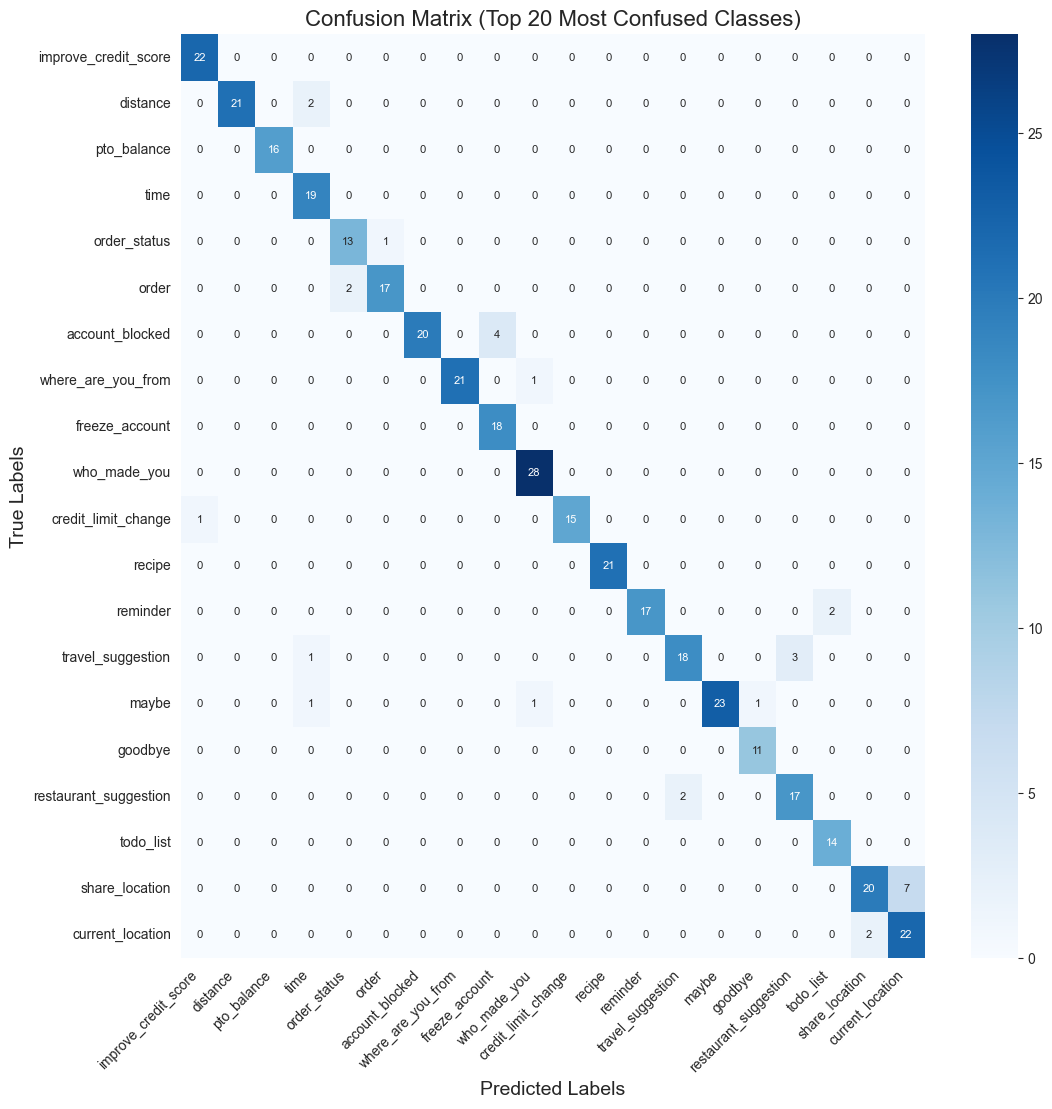

In [40]:
# Set SVM classifier
def create_classifier():
    return Pipeline([
        ('tfidf', TfidfVectorizer(
            ngram_range=(1, 3),
            max_features=5000,
            min_df=2,
            use_idf=True,
            sublinear_tf=True
        )),
        ('classifier', LinearSVC())
    ])



def main():
    
    
    # Get train, validation and test sets
    X_train, y_train, X_val, y_val, X_test, y_test, label_to_id, id_to_label = load_data()
    
    
    
    # ----- Validation Set



    feature_extractor = FeatureExtractor()

    print("Preprocessing training data...")
    X_train_processed = [feature_extractor.preprocess_text(text) for text in X_train]
    print("Preprocessing validation data...")
    X_val_processed = [feature_extractor.preprocess_text(text) for text in X_val]
    
    
    
    # --- Hyperparameter tuning

    # Initialize a classifier
    classifier = create_classifier()

    print("Tuning hyperparameters...")
    param_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
        'tfidf__max_features': [5000, 10000, None],
        'tfidf__min_df': [1, 2, 5],
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__loss': ['hinge', 'squared_hinge']
    }

    grid_search = GridSearchCV(classifier, param_grid, scoring='f1_macro', cv=3, verbose=2, n_jobs=-1)
    grid_search.fit(X_train_processed, y_train)

    print("Best hyperparameters:")
    print(grid_search.best_params_)



    # --- Evaluation
    
    # Evaluate on validation set
    print("Evaluating on validation set...")
    best_classifier = grid_search.best_estimator_
    y_val_pred = best_classifier.predict(X_val_processed)

    val_f1 = f1_score(y_val, y_val_pred, average='macro')
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred, average='macro')
    val_recall = recall_score(y_val, y_val_pred, average='macro')

    print("\nValidation Metrics:")
    print(f"F1-Score: {val_f1:.4f}")
    print(f"Accuracy: {val_accuracy:.4f}")
    print(f"Precision: {val_precision:.4f}")
    print(f"Recall: {val_recall:.4f}")



    # ----- Test Set
    
    
    
    # Preprocess test data
    print("Preprocessing test data...")
    X_test_processed = [feature_extractor.preprocess_text(text) for text in X_test]

    # Evaluate test set
    print("Evaluating on test set...")
    y_test_pred = best_classifier.predict(X_test_processed)

    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average='macro')
    test_recall = recall_score(y_test, y_test_pred, average='macro')

    print("\nTest Metrics:")
    print(f"F1-Score: {test_f1:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")

    
    
    # ----- Plotting Results
    
    # Plot confusion matrix
    print("Plotting Confusion Matrix for Test Set...")
    labels = [id_to_label[i] for i in sorted(label_to_id.values())]
    plot_confusion_matrix(y_test, y_test_pred, labels, "svm_tuned_confusion_matrix.pdf")

    # Plot precision-recall curves
    
    print("Plotting Precision-Recall Curves...")
    
    
    # binarizing labels
    n_classes = len(label_to_id)
    y_test_binarized = label_binarize(y_test, classes=sorted(label_to_id.values()))

    # Get decision function scores and ensure proper shape
    y_test_pred_scores = best_classifier.decision_function(X_test_processed)
    if len(y_test_pred_scores.shape) == 1:

        # For binary classification
        y_test_pred_scores = y_test_pred_scores.reshape(-1, 1)
        y_test_pred_scores = np.hstack([1 - y_test_pred_scores, y_test_pred_scores])

    # plotting precision recall curves for 20 most confused classes
    plot_precision_recall_curves(
        y_test_binarized,
        y_test_pred,
        y_test_pred_scores,
        labels,
        "svm_precision_recall_curves_most_confused.pdf"
    )


    # Save the metrics
    svm_metrics = {
        'Validation F1-Score': val_f1,
        'Validation Accuracy': val_accuracy,
        'Validation Precision': val_precision,
        'Validation Recall': val_recall,
        'Test F1-Score': test_f1,
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test Recall': test_recall
    }

    return svm_metrics


if __name__ == "__main__":
    svm_metrics = main()
    print("\nFinal Metrics:")
    for metric, value in svm_metrics.items():
        print(f"{metric}: {value:.4f}")